In [2]:
"""
XGBoost multiclassifier for roof materials in D.C.
"""

import os, sys, glob, time
import geopandas as gpd
import pandas as pd
import numpy as np
import rioxarray as rxr
import rasterio as rio
import xgboost as xgb
import gc

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score

# Functions script import
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

print(os.getcwd())

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'
# homedir = '/home/jovyan/data-store/data/iplant/home/maco4303/data/' # cyverse

print("Imports successful!")

/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/code
Imports successful!


In [2]:
# Load the image data

In [3]:
# Load our image data to check on the format
stack_da_fp = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_final_norm.tif')
# stack_da_fp = os.path.join(homedir,'OPP/planet/dc/dc_0623_psscene8b_final_norm.tif') # cyverse

stack_da = rxr.open_rasterio(stack_da_fp, masked=True, cache=False).squeeze()
print_raster(stack_da, open_file=False)
band_names = list(stack_da.long_name)
print(f"Band names: {band_names}")
del stack_da

shape: (8223, 6714)
resolution: (3.0, -3.0)
bounds: (315267.0, 4294629.0, 335409.0, 4319298.0)
sum: 8.181640625
CRS: EPSG:32618
NoData: None
Band names: ['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5']


In [4]:
# Prep the data columns
band_names_plus = band_names
band_names_plus.append('class_code')
band_names_plus.append('uid')
band_names_plus

['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5', 'class_code', 'uid']

In [9]:
# Load the training data (footprints)
ref_fp = os.path.join(maindir,'data/spatial/mod/dc_data/training/dc_data_reference_footprints_sampled.gpkg')
# ref_fp = os.path.join(homedir,'OPP/training/dc/dc_data_reference_footprints_sampled.gpkg')
ref = gpd.read_file(ref_fp)
ref.head()

,uid,class_code,description,areaUTMsqft,lotSizeSqft,nir,NDBIbg,NDBIrg,NISI,MNF1,NISI5x5,geometry
0,1CS,CS,Composition Shingle,357.783709,5574.0,-0.246291,0.373826,0.472331,0.204085,0.080244,2.598158,"POLYGON ((324215.868 4313568.665, 324215.792 4..."
1,3CS,CS,Composition Shingle,918.640862,1111.0,-0.856021,0.632535,1.064584,1.001515,0.569262,0.367447,"POLYGON ((324602.816 4311717.247, 324604.322 4..."
2,9CS,CS,Composition Shingle,1383.414170,4222.0,-0.864054,0.813552,0.806408,0.734980,0.218044,-0.683204,"POLYGON ((327253.581 4300371.859, 327258.154 4..."
3,19CS,CS,Composition Shingle,836.410297,3450.0,-0.735984,0.305262,0.856115,0.508690,0.070037,0.680645,"POLYGON ((333608.13 4306267.691, 333607.957 43..."
4,27CS,CS,Composition Shingle,330.514264,4352.0,-0.418819,0.516599,0.897064,0.448048,0.185206,-0.394834,"POLYGON ((326482.699 4300939.466, 326487.386 4..."


In [10]:
print(ref['class_code'].value_counts())

class_code
CS    37133
ME    36864
SL    15267
UR     1279
WS     1152
TL      924
SH      783
Name: count, dtype: int64


In [8]:
# Create a balanced sample

In [11]:
ref.columns

Index(['uid', 'class_code', 'description', 'areaUTMsqft', 'lotSizeSqft', 'nir',
       'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5', 'geometry'],
      dtype='object')

In [12]:
# Create a numeric code column
ref['code'], _ = pd.factorize(ref['class_code'])
# Create a dictionary mapping class_code to code
class_mapping = dict(zip(ref['class_code'], ref['code']))
desc_mapping = dict(zip(ref['class_code'], ref['description']))
print(f"Class mapping: {class_mapping}\nDescription mapping: {desc_mapping}")

Class mapping: {'CS': 0, 'ME': 1, 'SL': 2, 'UR': 3, 'TL': 4, 'WS': 5, 'SH': 6}
Description mapping: {'CS': 'Composition Shingle', 'ME': 'Metal', 'SL': 'Slate', 'UR': 'Urethane', 'TL': 'Tile', 'WS': 'Wood shake/shingle', 'SH': 'Shingle'}


In [13]:
# Perform balanced sampling (random undersampling)
ref_bal = balance_sampling(ref, ratio=10, strategy='undersample')
ref_bal.class_code.value_counts()

class_code
CS    7830
ME    7830
SL    7830
UR    1279
WS    1152
TL     924
SH     783
Name: count, dtype: int64

In [14]:
band_names

['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5']

In [ ]:
# Parameter tuning

In [ ]:
# Model run

In [15]:
t0 = time.time()

y = ref_bal['code'] # class code
X = ref_bal[band_names].astype(float) # the image data

# Define dataframes to store results for this feature set
results = pd.DataFrame()  # to store the model performance metrics
feat_imps = pd.DataFrame()  # to store the feature importances
prob_preds = pd.DataFrame()  # for testing optimum cutoff

# Set up the stratified K-fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Loop the folds
fold_idx = 1
for train_index, test_index in skf.split(X, y):
    t00 = time.time()
    print(f'Fold: {fold_idx}')

    # Split into train/test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Calculate class weights
    val_counts = list(y_train.value_counts())
    class_weights = [sum(val_counts) / count for count in val_counts]
    class_weights = class_weights / np.array(class_weights).sum()     # Normalize the weights
    class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}
    print(f"Normalized class weights: {class_weights_dict}")
    
    # Map class weights to each sample in the training set
    sample_weights = y_train.map(class_weight_dict).values

    # Initialize the XGBoost classifier for multi-class classification
    xgb_model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(np.unique(y)),
        n_estimators=1001,
        learning_rate=0.01,
        max_depth=8,
        random_state=42
    )

    # Fit the model
    xgb_model.fit(X_train, y_train, sample_weight=sample_weights)

    # Store feature importance
    fold_imps = pd.DataFrame({
        'Fold': fold_idx,
        'Feature': X.columns,
        'Importance': xgb_model.feature_importances_
    })

    feat_imps = pd.concat([feat_imps, fold_imps], axis=0)

    # Predict on the test set
    y_pred = xgb_model.predict(X_test)

    # Retrieve the accuracy/performance metrics
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Store the metrics into the results data frame
    fold_results = pd.DataFrame({
        'Fold': [fold_idx],
        'Precision': [precision],
        'Recall': [recall],
        'F1': [f1],
        'MCC': [mcc],
        'Accuracy': [accuracy]
    })
    results = pd.concat([results, fold_results], ignore_index=True)

    # Store the probability values for cutoff testing
    y_pred_proba = xgb_model.predict_proba(X_test)

    # Store probabilities and true labels
    fold_probs = pd.DataFrame({
        'TrueLabel': y_test,
        'PredictedProb': list(y_pred_proba),
        'Fold': fold_idx
    })

    # Concatenate the feature importances and probabilities
    prob_preds = pd.concat([prob_preds, fold_probs], ignore_index=True)

    fold_idx += 1 # fold counter

    del fold_probs, fold_results, fold_imps
    gc.collect()

    t1 = (time.time() - t00) / 60
    print(f"Total elapsed time for fold {fold_idx}: {t1:.2f} minutes.")
    print("\n~~~~~~~~~~\n")

t2 = (time.time() - t0) / 60
print(f"Total elapsed time: {t2:.2f} minutes.")

# # Append the feature set-specific results to the overall results dataframes
# all_results = pd.concat([all_results, results], ignore_index=True)
# all_feat_imps = pd.concat([all_feat_imps, feat_imps], ignore_index=True)
# all_prob_preds = pd.concat([all_prob_preds, prob_preds], ignore_index=True)

# del results, feat_imps, prob_preds

Fold: 1
Normalized class weights: {0: 0.01519441059309522, 1: 0.01519441059309522, 2: 0.015585882307065797, 3: 0.18605562371770987, 4: 0.20650918312351405, 5: 0.2577015919363225, 6: 0.30375889772919723}
Total elapsed time for fold 2: 0.28 minutes.

~~~~~~~~~~

Fold: 2
Normalized class weights: {0: 0.01519441059309522, 1: 0.01519441059309522, 2: 0.015585882307065797, 3: 0.18605562371770987, 4: 0.20650918312351405, 5: 0.2577015919363225, 6: 0.30375889772919723}
Total elapsed time for fold 3: 0.28 minutes.

~~~~~~~~~~

Fold: 3
Normalized class weights: {0: 0.0151925610778026, 1: 0.0151925610778026, 2: 0.01558398514050581, 3: 0.18603297639491734, 4: 0.2064840461239632, 5: 0.25736052383479546, 6: 0.30415334635021285}
Total elapsed time for fold 4: 0.27 minutes.

~~~~~~~~~~

Fold: 4
Normalized class weights: {0: 0.0151925610778026, 1: 0.0151925610778026, 2: 0.01558398514050581, 3: 0.18603297639491734, 4: 0.2064840461239632, 5: 0.25736052383479546, 6: 0.30415334635021285}
Total elapsed time f

In [16]:
results.head()

,Fold,Precision,Recall,F1,MCC,Accuracy
0,1,0.599565,0.439385,0.493615,0.307817,0.439385
1,2,0.596827,0.441356,0.497292,0.307139,0.441356
2,3,0.585360,0.430712,0.485600,0.294947,0.430712
3,4,0.594596,0.437020,0.491725,0.303645,0.437020
4,5,0.594489,0.432880,0.487081,0.301198,0.432880


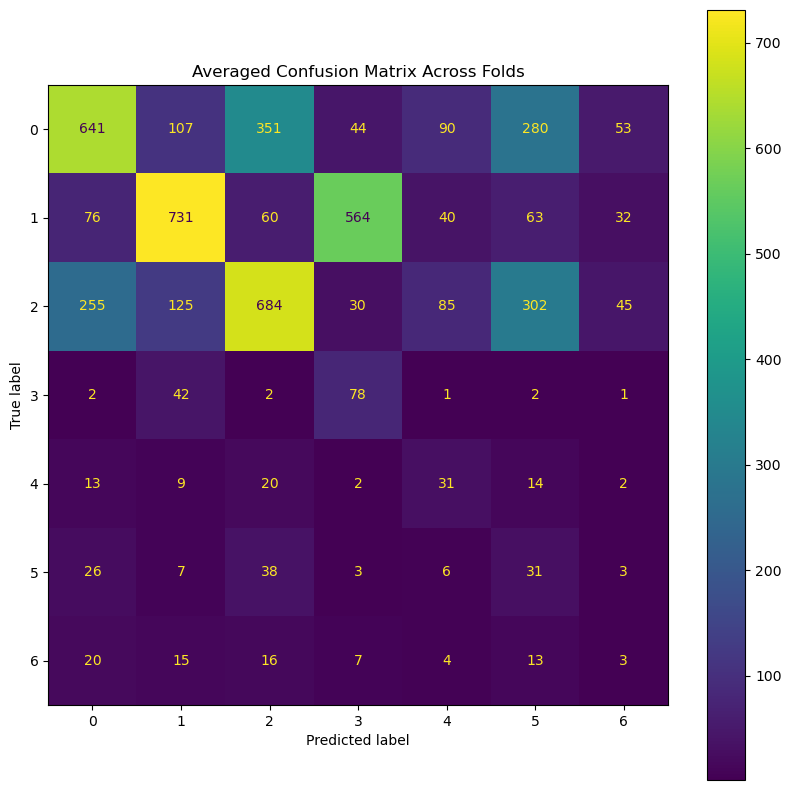

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Initialize the confusion matrix accumulator
n_classes = len(np.unique(y))  # Number of classes
cm_accumulator = np.zeros((n_classes, n_classes))

all_true_labels = []
all_pred_labels = []

class_acc_reports = []

# Loop over the folds and compute confusion matrices
for fold in range(1, fold_idx):
    fold_data = prob_preds[prob_preds['Fold'] == fold]
    true_labels = fold_data['TrueLabel']
    pred_labels = np.argmax(np.vstack(fold_data['PredictedProb']), axis=1)

    all_true_labels.extend(true_labels)
    all_pred_labels.extend(pred_labels)

    # Compute the classification report for this fold
    cr_fold = classification_report(true_labels, pred_labels, target_names=cor_labels, output_dict=True)
    # Convert the classification report to a DataFrame and store it
    cr_df_fold = pd.DataFrame(cr_fold).transpose()
    class_acc_reports.append(cr_df_fold)
    
    # Compute the confusion matrix for this fold
    cm_fold = confusion_matrix(true_labels, pred_labels, labels=np.unique(y))

    # Accumulate the confusion matrix
    cm_accumulator += cm_fold

# Average the confusion matrix by the number of folds
cm_avg = cm_accumulator / (fold_idx - 1)

# Round to the nearest integer (optional, as you mentioned it's fine)
cm_avg = np.rint(cm_avg).astype(int)

# Display the averaged confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_avg, display_labels=np.unique(y))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
plt.title('Averaged Confusion Matrix Across Folds')

# Save the figure
plt.savefig(os.path.join('/home/jovyan/data-store/results/FigX_xgboost_confusion_matrix_avg.png'), dpi=300, bbox_inches='tight')

plt.show()

In [24]:
cr_avg = pd.concat(class_acc_reports).groupby(level=0).mean()
print(cr_avg)

              precision    recall  f1-score      support
CS             0.621601  0.409579  0.493694  1566.000000
ME             0.706062  0.466858  0.561915  1566.000000
SH             0.025236  0.043460  0.031758    78.300000
SL             0.583665  0.448222  0.506972  1526.700000
TL             0.118675  0.331265  0.174600    92.400000
UR             0.107669  0.613736  0.183174   127.900000
WS             0.044571  0.272601  0.076608   115.200000
accuracy       0.433849  0.433849  0.433849     0.433849
macro avg      0.315354  0.369389  0.289817  5072.500000
weighted avg   0.591828  0.433849  0.488505  5072.500000


In [20]:
from sklearn.metrics import classification_report

# Create a classification report and convert it to a DataFrame
cor_labels = [label for label, idx in sorted(class_mapping.items(), key=lambda item: item[1])]
cr_df = pd.DataFrame(classification_report(all_true_labels, all_pred_labels, target_names=cor_labels, output_dict=True)).transpose()

# Compute the average accuracy metrics across the 10 folds
average_metrics = cr_df.loc[cor_labels].mean()

# Display the DataFrame
cr_df

,precision,recall,f1-score,support
CS,0.621211,0.409579,0.493669,15660.000000
ME,0.705831,0.466858,0.561996,15660.000000
SL,0.583525,0.448222,0.507002,15267.000000
UR,0.107800,0.613761,0.183390,1279.000000
TL,0.118697,0.331169,0.174757,924.000000
WS,0.044495,0.272569,0.076501,1152.000000
SH,0.024320,0.043423,0.031178,783.000000
accuracy,0.433849,0.433849,0.433849,0.433849
macro avg,0.315126,0.369369,0.289785,50725.000000
weighted avg,0.591582,0.433849,0.488530,50725.000000


In [21]:
# Save out the results
results_dir = '/home/jovyan/data-store/results/'
results.to_csv(os.path.join(results_dir,'dc_xgboost_folds_results.csv'))
feat_imps.to_csv(os.path.join(results_dir,'dc_xgboost_folds_feat_imps.csv'))
prob_preds.to_csv(os.path.join(results_dir,'dc_xgboost_folds_prob_peds.csv'))
cr_df.to_csv(os.path.join(results_dir,'dc_xgboost_classification_report_avg.csv'))